# Phase Transitions: States of Dead Token Matter

Classify dead tokens into phases based on their lattice displacement magnitude |ΔW′|.

**Phases (from box_3 vocabulary):**
- **Fimbulwinter:** |ΔW′| < 0.1 ULP — frozen, no observable motion
- **Thermal Solid:** 0.1–10 ULP — slow drift, sub-lattice vibrations
- **Quantum Regime:** 10–100 ULP — significant hopping
- **Classical Gas:** > 100 ULP — free flight, supernova territory

**Input:** `box_4/tensors/Thimble-8/lattice_displacement.safetensors`

## Parameters

In [1]:
# Paths
INPUT_PATH = '../../tensors/Thimble-8/lattice_displacement.safetensors'

# Phase thresholds (in ULP / lattice cells)
THRESH_FIMBULWINTER = 0.1   # Below this: frozen
THRESH_THERMAL = 10.0       # Below this: thermal solid
THRESH_QUANTUM = 100.0      # Below this: quantum regime; above: classical gas

# Plotting
DPI = 150
FIGSIZE = (14, 6)

## Imports

In [2]:
import torch
from safetensors.torch import load_file
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [3]:
data = load_file(INPUT_PATH)
delta_W_prime = data['delta_W_prime']  # (4000, 3699, 64) float32

n_steps, n_tokens, n_dims = delta_W_prime.shape
print(f"Shape: {delta_W_prime.shape}")
print(f"Steps: {n_steps}, Dead tokens: {n_tokens}, Dims: {n_dims}")

Shape: torch.Size([4000, 3699, 64])
Steps: 4000, Dead tokens: 3699, Dims: 64


## Compute Per-Token Displacement Magnitude

For each token at each timestep, compute the L2 norm of ΔW′ across dimensions.
This gives a single scalar "how far did this token move" per token per step.

In [4]:
# |ΔW′|₂ for each token at each step
# Shape: (4000, 3699)
displacement_magnitude = torch.norm(delta_W_prime, dim=2)

print(f"Displacement magnitude shape: {displacement_magnitude.shape}")
print(f"Range: [{displacement_magnitude.min():.4f}, {displacement_magnitude.max():.4f}]")

Displacement magnitude shape: torch.Size([4000, 3699])
Range: [0.0000, inf]


## Classify Into Phases

In [5]:
# Classify each token at each timestep
is_fimbulwinter = displacement_magnitude < THRESH_FIMBULWINTER
is_thermal = (displacement_magnitude >= THRESH_FIMBULWINTER) & (displacement_magnitude < THRESH_THERMAL)
is_quantum = (displacement_magnitude >= THRESH_THERMAL) & (displacement_magnitude < THRESH_QUANTUM)
is_classical = displacement_magnitude >= THRESH_QUANTUM

# Compute fractions at each timestep
frac_fimbulwinter = is_fimbulwinter.float().mean(dim=1).numpy()
frac_thermal = is_thermal.float().mean(dim=1).numpy()
frac_quantum = is_quantum.float().mean(dim=1).numpy()
frac_classical = is_classical.float().mean(dim=1).numpy()

# Sanity check: fractions should sum to 1
total = frac_fimbulwinter + frac_thermal + frac_quantum + frac_classical
print(f"Fraction sum range: [{total.min():.6f}, {total.max():.6f}] (should be 1.0)")

Fraction sum range: [1.000000, 1.000000] (should be 1.0)


## Stacked Area Plot

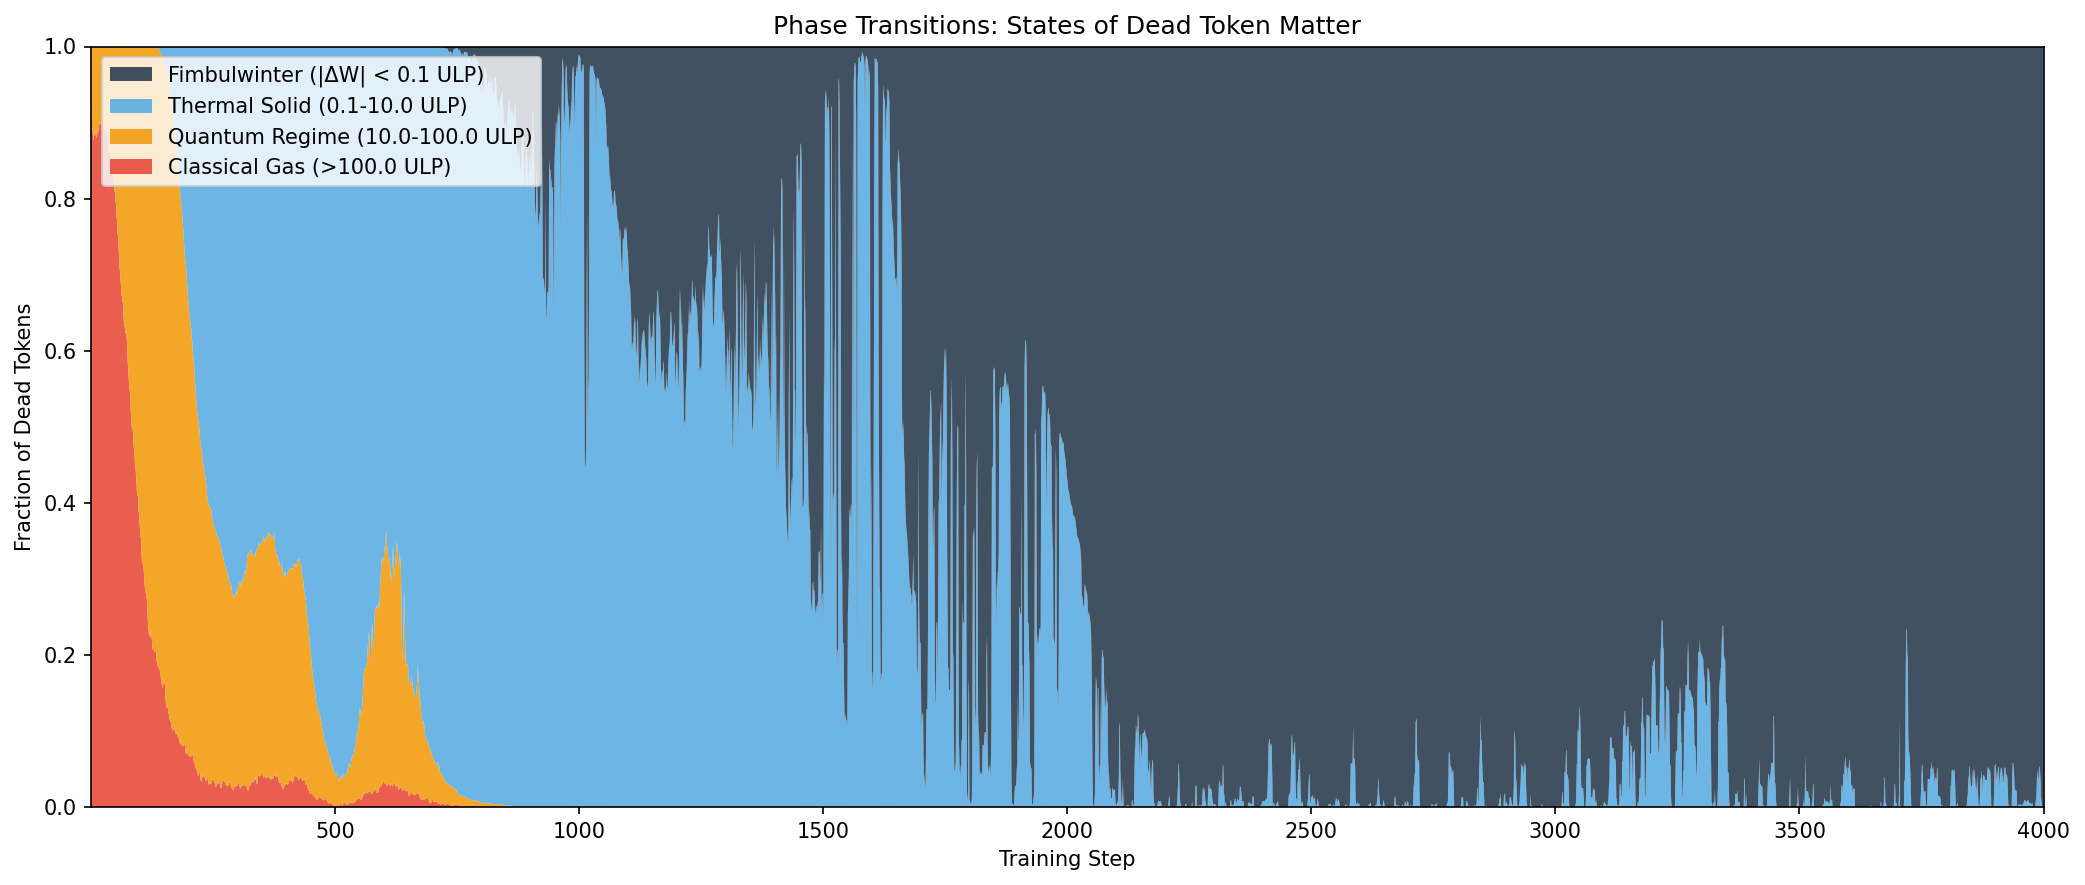

In [6]:
steps = np.arange(1, n_steps + 1)  # 1 to 4000

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Stack from bottom to top: Classical (red), Quantum (orange), Thermal (light blue), Fimbulwinter (dark blue)
ax.stackplot(
    steps,
    frac_classical,
    frac_quantum,
    frac_thermal,
    frac_fimbulwinter,
    labels=[
        f'Classical Gas (>{THRESH_QUANTUM} ULP)',
        f'Quantum Regime ({THRESH_THERMAL}-{THRESH_QUANTUM} ULP)',
        f'Thermal Solid ({THRESH_FIMBULWINTER}-{THRESH_THERMAL} ULP)',
        f'Fimbulwinter (|ΔW| < {THRESH_FIMBULWINTER} ULP)',
    ],
    colors=['#e74c3c', '#f39c12', '#5dade2', '#2c3e50'],
    alpha=0.9
)

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction of Dead Tokens')
ax.set_title('Phase Transitions: States of Dead Token Matter')
ax.set_xlim(1, n_steps)
ax.set_ylim(0, 1)

# Legend in reverse order to match visual stacking
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')

plt.tight_layout()
plt.show()

## Key Statistics

In [7]:
print("=" * 60)
print("PHASE TRANSITION STATISTICS")
print("=" * 60)

# When does Fimbulwinter first reach 50%? 90%? 99%?
for threshold in [0.5, 0.9, 0.99]:
    idx = np.where(frac_fimbulwinter >= threshold)[0]
    if len(idx) > 0:
        step = idx[0] + 1  # +1 because steps are 1-indexed
        print(f"Fimbulwinter reaches {threshold:.0%} at step {step}")
    else:
        print(f"Fimbulwinter never reaches {threshold:.0%}")

print()

# When does Classical Gas drop below 1%? 0.1%? 0%?
for threshold in [0.01, 0.001, 0.0]:
    idx = np.where(frac_classical <= threshold)[0]
    if len(idx) > 0:
        step = idx[0] + 1
        print(f"Classical Gas drops below {threshold:.1%} at step {step}")
    else:
        print(f"Classical Gas never drops below {threshold:.1%}")

print()

# Final state
print(f"Final state (step {n_steps}):")
print(f"  Fimbulwinter: {frac_fimbulwinter[-1]:.1%}")
print(f"  Thermal Solid: {frac_thermal[-1]:.1%}")
print(f"  Quantum Regime: {frac_quantum[-1]:.1%}")
print(f"  Classical Gas: {frac_classical[-1]:.1%}")

PHASE TRANSITION STATISTICS
Fimbulwinter reaches 50% at step 1012
Fimbulwinter reaches 90% at step 1702
Fimbulwinter reaches 99% at step 1796

Classical Gas drops below 1.0% at step 464
Classical Gas drops below 0.1% at step 740
Classical Gas drops below 0.0% at step 797

Final state (step 4000):
  Fimbulwinter: 100.0%
  Thermal Solid: 0.0%
  Quantum Regime: 0.0%
  Classical Gas: 0.0%


## Mean Displacement Over Time

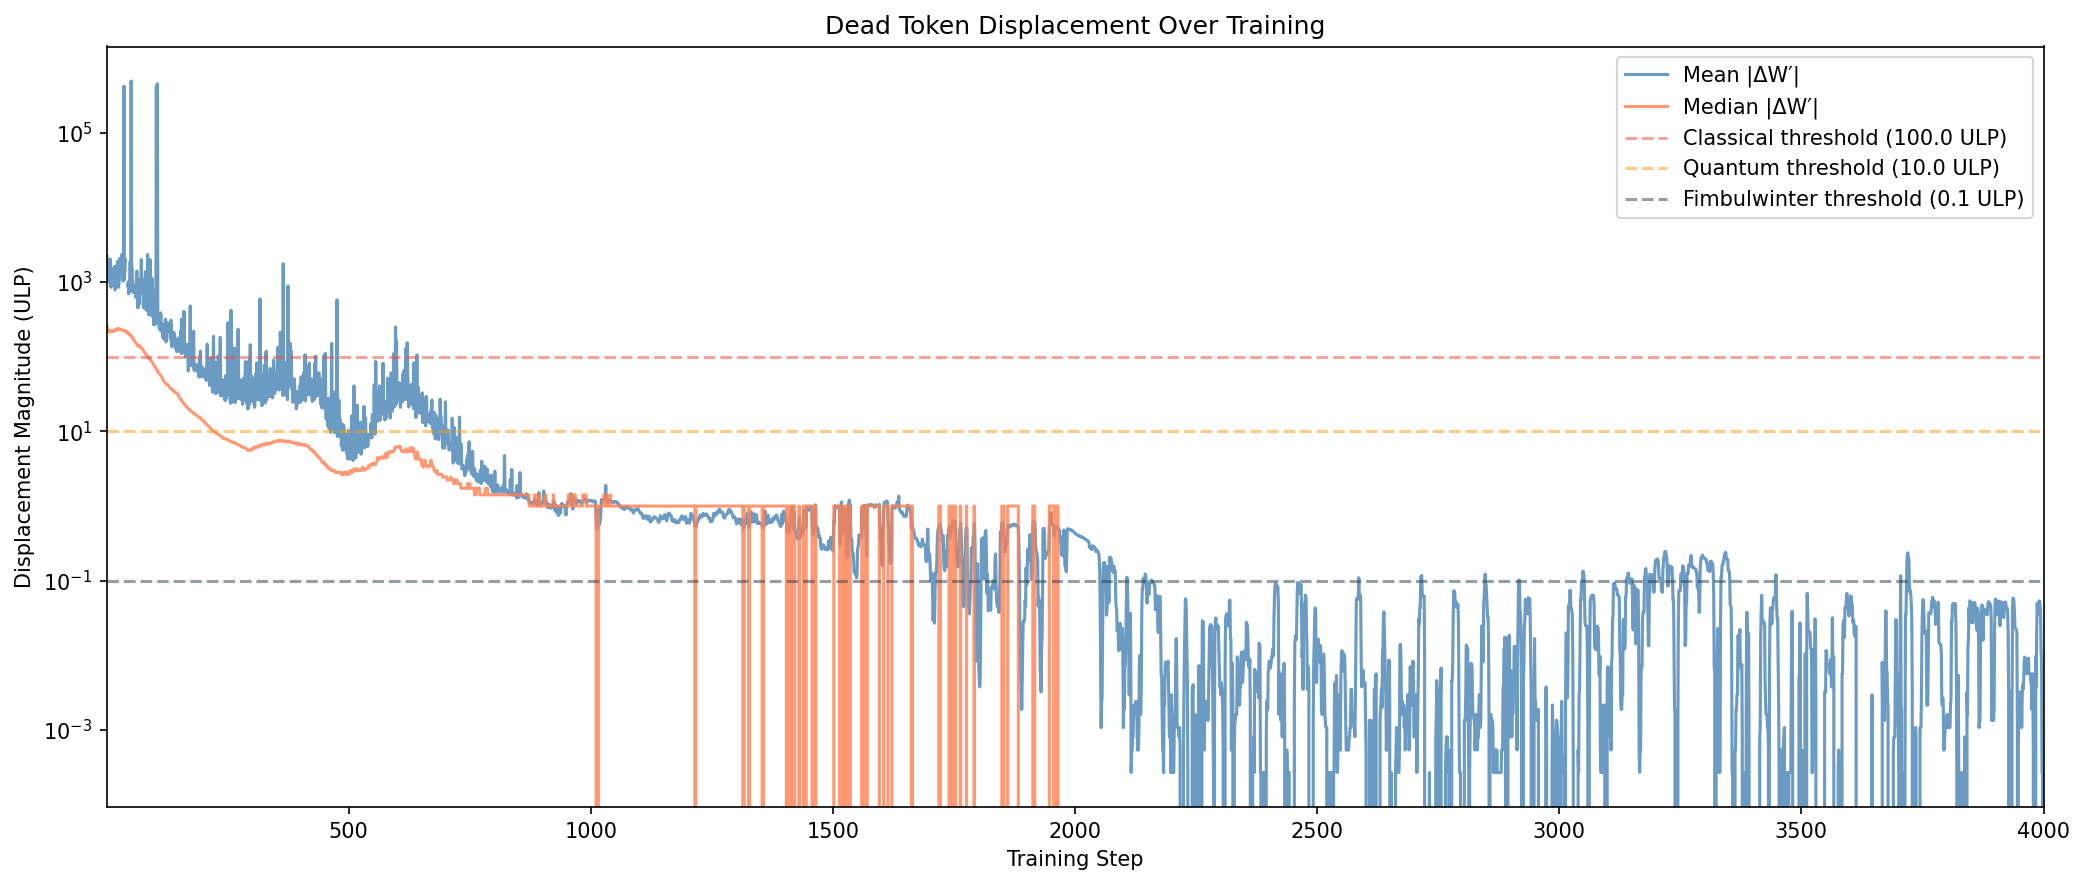

In [8]:
# Mean and median displacement across all dead tokens at each step
mean_displacement = displacement_magnitude.mean(dim=1).numpy()
median_displacement = displacement_magnitude.median(dim=1).values.numpy()

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.semilogy(steps, mean_displacement, label='Mean |ΔW′|', color='steelblue', alpha=0.8)
ax.semilogy(steps, median_displacement, label='Median |ΔW′|', color='coral', alpha=0.8)

# Add threshold lines
ax.axhline(THRESH_QUANTUM, color='#e74c3c', linestyle='--', alpha=0.5, label=f'Classical threshold ({THRESH_QUANTUM} ULP)')
ax.axhline(THRESH_THERMAL, color='#f39c12', linestyle='--', alpha=0.5, label=f'Quantum threshold ({THRESH_THERMAL} ULP)')
ax.axhline(THRESH_FIMBULWINTER, color='#2c3e50', linestyle='--', alpha=0.5, label=f'Fimbulwinter threshold ({THRESH_FIMBULWINTER} ULP)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Displacement Magnitude (ULP)')
ax.set_title('Dead Token Displacement Over Training')
ax.set_xlim(1, n_steps)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()